In [45]:
!pip install opacus

  Using cached opacus-0.15.0-py3-none-any.whl (125 kB)


In [46]:
!pip install codecarbon

  Using cached codecarbon-1.2.0-py3-none-any.whl (135 kB)
  Using cached py_cpuinfo-8.0.0-py3-none-any.whl
  Using cached dash-2.2.0-py3-none-any.whl (8.5 MB)
  Using cached dash_bootstrap_components-1.0.3-py3-none-any.whl (209 kB)
  Using cached pynvml-11.4.1-py3-none-any.whl (46 kB)
     |████████████████████████████████| 59 kB 1.5 MB/s             
  Using cached fire-0.4.0-py2.py3-none-any.whl
  Using cached tzlocal-4.1-py3-none-any.whl (19 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached pytz_deprecation_shim-0.1.0.post0-py2.py3-none-any.whl (15 kB)
  Using cached backports.zoneinfo-0.2.1-cp36-cp36m-manylinux1_x86_64.whl (70 kB)
  Using cached Brotli-1.0.9-cp36-cp36m-manylinux1_x86_64.whl (357 kB)
  Using cached tzdata-2021.5-py2.py3-none-any.whl (339 kB)


In [47]:
!pip install captum

     |████████████████████████████████| 1.4 MB 24.3 MB/s            


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from codecarbon import EmissionsTracker as ET
from opacus import PrivacyEngine

from captum.attr import IntegratedGradients

In [91]:
# Load data from csv file
df = pd.read_csv('../data/titanic.csv')
df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

categorical_columns = ['Sex', 'Embarked']
df_cleaned = pd.get_dummies(df, prefix=categorical_columns)
df_cleaned['Age'].fillna(inplace= True, method='bfill' )

df_cleaned.head()

,target,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [92]:
df_cleaned.isna().sum()

target        0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [93]:
# converting dataframe to numpy array
labels = df_cleaned["target"].to_numpy()

df_cleaned = df_cleaned.drop(['target'], axis=1)
feature_names = list(df_cleaned.columns)
features = df_cleaned.to_numpy()

# loading data into torch tensor
feature_tensor = torch.from_numpy(features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(labels)

# loading data into torch dataset
train_dataset = torch.utils.data.TensorDataset(feature_tensor, label_tensor)

# loading data into torch dataloader
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [94]:
feature_tensor.shape

torch.Size([891, 10])

In [95]:
class TitanicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(10, 10)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(10, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [96]:
def train(trainloader, model, optimizer):
    
    loss_fn = nn.CrossEntropyLoss()
    epochs = 100
    
    for epoch in range(epochs):
        for i, (features, label) in enumerate(train_dataloader):
            # Forward pass
            y_pred = model(features)
            loss = loss_fn(y_pred, label)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, epochs, i+1, len(train_dataloader), loss.item()))
    
    return model
    

In [97]:
# Calculate Emissions
tracker = ET(project_name = "churn_prediction",
                           output_dir = "../output/",
                           measure_power_secs = 15,
                           save_to_file = True)

tracker.start()

INFO:apscheduler.scheduler:Adding job tentatively -- it will be properly scheduled when the scheduler starts
INFO:apscheduler.scheduler:Added job "BaseEmissionsTracker._measure_power" to job store "default"
INFO:apscheduler.scheduler:Scheduler started


In [98]:
vanilla_model = TitanicModel()

optimizer = torch.optim.Adam(vanilla_model.parameters(), lr=0.001)

trained_vanilla_model = train(train_dataloader, vanilla_model, optimizer)

Epoch [1/100], Step [10/28], Loss: 0.6830
Epoch [1/100], Step [20/28], Loss: 0.6740
Epoch [2/100], Step [10/28], Loss: 0.6781
Epoch [2/100], Step [20/28], Loss: 0.6528
Epoch [3/100], Step [10/28], Loss: 0.6915
Epoch [3/100], Step [20/28], Loss: 0.6240
Epoch [4/100], Step [10/28], Loss: 0.6439
Epoch [4/100], Step [20/28], Loss: 0.6390
Epoch [5/100], Step [10/28], Loss: 0.6381
Epoch [5/100], Step [20/28], Loss: 0.6579
Epoch [6/100], Step [10/28], Loss: 0.6706
Epoch [6/100], Step [20/28], Loss: 0.6546
Epoch [7/100], Step [10/28], Loss: 0.6129
Epoch [7/100], Step [20/28], Loss: 0.6607
Epoch [8/100], Step [10/28], Loss: 0.7060
Epoch [8/100], Step [20/28], Loss: 0.6877
Epoch [9/100], Step [10/28], Loss: 0.6790
Epoch [9/100], Step [20/28], Loss: 0.5776
Epoch [10/100], Step [10/28], Loss: 0.7145
Epoch [10/100], Step [20/28], Loss: 0.6667
Epoch [11/100], Step [10/28], Loss: 0.6124
Epoch [11/100], Step [20/28], Loss: 0.6373
Epoch [12/100], Step [10/28], Loss: 0.6713
Epoch [12/100], Step [20/28],

In [99]:
# Calculate Differential Privacy
noise_multiplier = 5
max_per_sample_grad_norm = 1.5
sample_rate = batch_size/len(train_dataset)

dp_model = TitanicModel()

optimizer = optim.Adam(dp_model.parameters(), weight_decay=0.0001, lr=0.003)

privacy_engine = PrivacyEngine(
    dp_model,
    max_grad_norm=max_per_sample_grad_norm,
    noise_multiplier = noise_multiplier,
    sample_rate = sample_rate,
)

privacy_engine.attach(optimizer)
trained_dp_model = train(train_dataloader, dp_model, optimizer)

Epoch [1/100], Step [10/28], Loss: 0.6628
Epoch [1/100], Step [20/28], Loss: 0.7179
Epoch [2/100], Step [10/28], Loss: 0.6627


/opt/conda/lib/python3.6/site-packages/opacus/privacy_engine.py:760: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/opt/conda/lib/python3.6/site-packages/opacus/privacy_engine.py:237: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py:796: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when 

Epoch [2/100], Step [20/28], Loss: 0.6784
Epoch [3/100], Step [10/28], Loss: 0.6902
Epoch [3/100], Step [20/28], Loss: 0.6628
Epoch [4/100], Step [10/28], Loss: 0.7175
Epoch [4/100], Step [20/28], Loss: 0.6909
Epoch [5/100], Step [10/28], Loss: 0.6885
Epoch [5/100], Step [20/28], Loss: 0.6244
Epoch [6/100], Step [10/28], Loss: 0.5996
Epoch [6/100], Step [20/28], Loss: 0.6499
Epoch [7/100], Step [10/28], Loss: 0.6773
Epoch [7/100], Step [20/28], Loss: 0.6247
Epoch [8/100], Step [10/28], Loss: 0.6399
Epoch [8/100], Step [20/28], Loss: 0.6263
Epoch [9/100], Step [10/28], Loss: 0.6517
Epoch [9/100], Step [20/28], Loss: 0.6881
Epoch [10/100], Step [10/28], Loss: 0.6200
Epoch [10/100], Step [20/28], Loss: 0.6658
Epoch [11/100], Step [10/28], Loss: 0.6766
Epoch [11/100], Step [20/28], Loss: 0.6553
Epoch [12/100], Step [10/28], Loss: 0.7096
Epoch [12/100], Step [20/28], Loss: 0.6566
Epoch [13/100], Step [10/28], Loss: 0.6769
Epoch [13/100], Step [20/28], Loss: 0.6554
Epoch [14/100], Step [10/2

INFO:apscheduler.executors.default:Running job "BaseEmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2022-03-10 17:01:17 UTC)" (scheduled at 2022-03-10 17:01:17.702083+00:00)
INFO:apscheduler.executors.default:Job "BaseEmissionsTracker._measure_power (trigger: interval[0:00:15], next run at: 2022-03-10 17:01:32 UTC)" executed successfully


In [100]:
epsilon, best_alpha = privacy_engine.get_privacy_spent()
print (f" ε = {epsilon:.2f}, δ = {privacy_engine.target_delta}")

 ε = 1.83, δ = 1e-06


In [101]:
emissions: float = tracker.stop()
print(emissions)

INFO:apscheduler.scheduler:Scheduler has been shut down


0.000219429418842438


In [102]:
# Explainability
from captum.attr import IntegratedGradients
ig = IntegratedGradients(trained_vanilla_model)

feature_tensor.requires_grad_()
attr, delta = ig.attribute(feature_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
Pclass :  -0.276
Age :  -0.176
SibSp :  -0.087
Parch :  -0.035
Fare :  0.579
Sex_female :  0.290
Sex_male :  -0.188
Embarked_C :  0.024
Embarked_Q :  0.013
Embarked_S :  -0.066


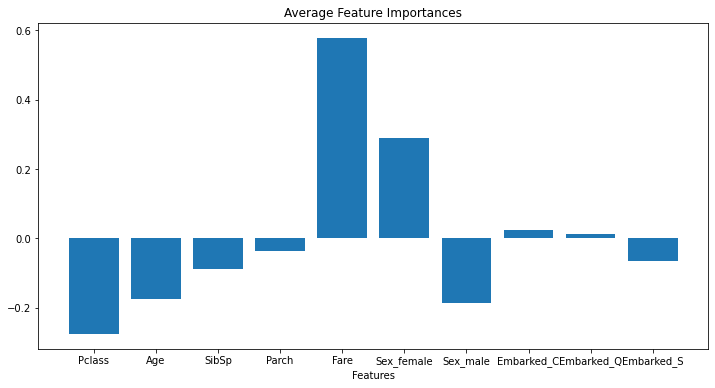

In [103]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

In [104]:
# Fairness


In [105]:
!carbonboard --filepath="../output/emissions.csv" --port=3333

/opt/conda/lib/python3.6/site-packages/codecarbon/viz/carbonboard.py:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/opt/conda/lib/python3.6/site-packages/codecarbon/viz/carbonboard.py:4: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt
/opt/conda/lib/python3.6/site-packages/codecarbon/viz/components.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
Traceback (most recent call last):
  File "/opt/conda/bin/carbonboard", line 8, in <module>
    sys.exit(main()